# Livrable 1 - Classification binaire

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [52]:
dataset_dir = r'C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1'  

In [53]:
import tensorflow as tf

# Vérifier si TensorFlow détecte le GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  []


## Rescale (normalisation)

Le paramètre rescale=1./255 normalise les valeurs des pixels de l'image en les divisant par 255. Cela signifie que les valeurs des pixels, qui sont normalement dans la plage de 0 à 255 (puisque les images sont généralement encodées en 8 bits), sont mises à l'échelle pour être comprises entre 0 et 1.

In [54]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

## Split des données

80% train 
20% validation

In [55]:
batch_size = 32

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 33120 images belonging to 5 classes.
Found 8279 images belonging to 5 classes.


### Création du modèle CNN 

In [56]:
model = Sequential()

In [57]:
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))


In [58]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [59]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [60]:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [61]:
model.add(Flatten())

In [62]:
model.add(Dense(128, activation='relu'))

In [63]:
model.add(Dropout(0.5))  # Dropout pour éviter le surapprentissage

In [64]:
model.add(Dense(64, activation='relu'))

In [65]:
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,961 (12.64 MB)

 Trainable params: 3,312,961 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## Entrainement du modèle

In [68]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 542s 520ms/step - accuracy: 0.2397 - loss: -5833980641280.0000 - val_accuracy: 0.2413 - val_loss: -285198646247424.0000
Epoch 2/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 495s 477ms/step - accuracy: 0.2404 - loss: -1559942725107712.0000 - val_accuracy: 0.2413 - val_loss: -13402723546300416.0000
Epoch 3/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 560s 539ms/step - accuracy: 0.2423 - loss: -27287967340953600.0000 - val_accuracy: 0.2413 - val_loss: -102893320329494528.0000
Epoch 4/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 596s 574ms/step - accuracy: 0.2408 - loss: -155357453951696896.0000 - val_accuracy: 0.2413 - val_loss: -404501737924198400.0000
Epoch 5/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 554s 534ms/step - accuracy: 0.2396 - loss: -543882154052943872.0000 - val_accuracy: 0.2413 - val_loss: -1135121854462164992.0000
Epoch 6/10
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 540s 520ms/step - accuracy: 0.2406 - loss: -1441340996758536192.0000 - val_accuracy: 0.2413 - val_loss: -26057650422593

## Sauvegarde des poids

In [75]:
model.save_weights('model.weights.h5')

# Performance du modèle 

In [76]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

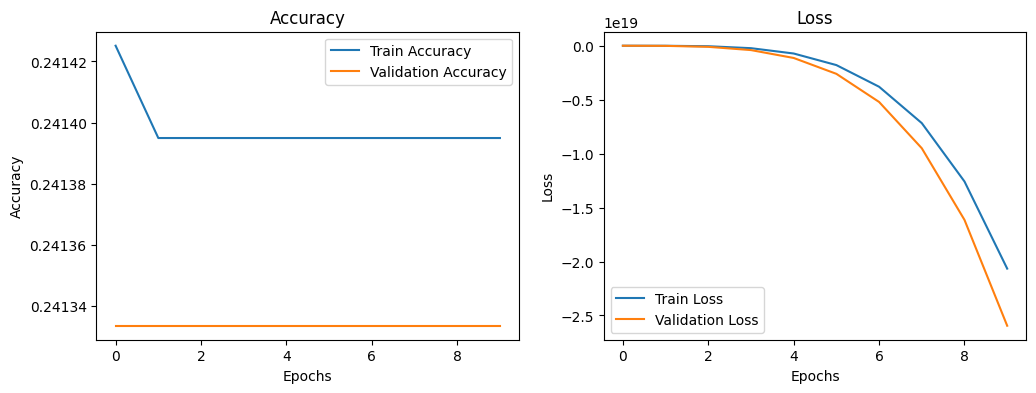

In [72]:
plot_training_history(history)

In [78]:
def predict_image(model_save,image_path):
    img = load_img(image_path, target_size=(128, 128)) 
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255. 

    prediction = model_save.predict(img_array)  
    if prediction[0] > 0.5:
        return "Picture"
    else:
        return "None-Picture"
    
def predict_random_image(model_save,dataset_dir):
    categories = ['Photo', 'Painting', 'Schematics', 'Sketch', 'Text']
    category = random.choice(categories)
    image_folder = os.path.join(dataset_dir, category)
    
    random_image = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, random_image)

    print(f"Image choisie aléatoirement : {image_path}")
    result = predict_image(model_save,image_path)
    print(f"Prédiction : {result}")



In [81]:
predict_random_image(model,dataset_dir)

Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Sketch\092_1_1_sz1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prédiction : Picture


# Utilisation des Poids Sauvegarder


In [82]:
model_save_weights = Sequential()

In [83]:
model_save_weights.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))
model_save_weights.add(Conv2D(32, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(64, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Conv2D(128, (3, 3), activation='relu'))
model_save_weights.add(MaxPooling2D(pool_size=(2, 2)))

model_save_weights.add(Flatten())
model_save_weights.add(Dense(128, activation='relu'))
model_save_weights.add(Dropout(0.5)) 
model_save_weights .add(Dense(64, activation='relu'))


model_save_weights.add(Dense(1, activation='sigmoid'))

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
model_save_weights.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
model.load_weights('model.weights.h5')

In [90]:
predict_random_image(model_save_weights,dataset_dir)

Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Sketch\178_1_1_sz1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prédiction : Picture


In [87]:
predict_random_image(model_save_weights,dataset_dir)

Image choisie aléatoirement : C:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\data_set_livrable_1\Sketch\1754.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prédiction : Picture
